# Physics-Informed Neural Networks

## Motivation

For years mathematicians and physicists are trying to model the world with differential equations. However, since the advent of techniques such as machine learning, neural networks and deep learning together with greater computing power, community has speculated that we could learn automatically (algorithms) anything with a enough amount of data. However, it seems this is not really true.

Philosophical Question: Could have a _machine_ discovered Newton's laws?

#### PINNs

In 2019, Raissi, Perdikaris and Karniadakis introduced Physics-Informed Neural Networks (PINNs), neural networks that are trained to solve supervised learning tasks while respecting any given law of physics described by general nonlinear partial differential equations ([source](https://www.sciencedirect.com/science/article/pii/S0021999118307125)). PINNs are nowadays used to solve PDEs, fractional equations, and integral-differential equations.

__Idea__

PINNs approximate PDE solutions by training a neural network to minimize a loss function, including:

* Initial and boundary conditions along the space-time domain’s boundary
* PDE residual at selected points in the domain.

If you want to do a simplified analogy, initial and boundary conditions points will be an usual training dataset, but also it is necessary to embed physical laws (PDE) into the neural network.

## Setup

PINNs can solve differential equations expressed, in the most general form, like:

$$
\begin{align*}
\mathcal{F}(u(z); \lambda) &= f(z) \quad z \text{ in } \Omega \\
\mathcal{B}(u(z)) &= g(z) \quad z \text{ in } \partial \Omega
\end{align*}
$$ 

defined on the domain $\Omega \subset \mathbb{R}^d$ with the boundary $\partial \Omega$. Where
- $z := (x_1, x_2, \ldots, t)^\top$ indicated the space-time coordinate vector,
- $u$ the unknown function,
- $\lambda$ the parameters related to the physics,
- $\mathcal{F}$ the non-linear differential operator,
- $f$ the function identifying the data of the problem,
- $\mathcal{B}$ the operator indicating arbitrary initial or boundary conditions, and
- $g$ the boundary function.

In the PINN methodology, $u(z)$ is computationally predicted by a NN, parametrized by a set of parameters $\theta$, giving rise to an approximation
$$
\hat{u}_\theta(z) \approx u(z)
$$

The optimization problem we want to deal with it is

$$
\min_\theta \; \omega_\mathcal{F} \mathcal{L}_\mathcal{F}(\theta) + \omega_\mathcal{B} \mathcal{L}_\mathcal{B}(\theta) + \omega_{\text{data}} \mathcal{L}_{\text{data}}(\theta)
$$

this is three weighted loss functions, each one depending on
- $\mathcal{L}_\mathcal{F}$, differential equation, 
- $\mathcal{L}_\mathcal{B}$, boundary conditions, and
- $\mathcal{L}_{\text{data}}$, (eventually) some known data.

![PINNs](../images/info_pinn.png)

[Source](https://link.springer.com/article/10.1007/s10915-022-01939-z)

## Implementation: DeepXDE

DeepXDE is a library for scientific machine learning and physics-informed learning. It support several tensor libraries as backend (TensorFlow, PyTorch, JAX, among other). 

One of its main features is that enables the user code to be compact, resembling closely the mathematical formulation. We don't have to worry much about the technical aspect of the code, but rather about the mathematical model.

![DeepXDE](../images/pinn.webp)

[Source](https://deepxde.readthedocs.io/en/latest/)

## Example: Burguers Equation

We will solve a Burquers equation

$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu\frac{\partial^2u}{\partial x^2}, \qquad x \in [-1, 1], \quad t \in [0, 1]
$$
with the Dirichlet boundary conditions and initial conditions
$$
u(-1,t)=u(1,t)=0, \quad u(x,0) = - \sin(\pi x).
$$

Official documentation tutorial [here](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/burgers.html).

__Remarks:__
- If you are working on Google Colab you need to install `DeepXDE` and enable GPU.
    1. `!pip install deepxde`
    2. Go to Menu `Menu > Runtime > Change Runtime` and change hardware accelaration to __GPU__.
- If you are working on your own machine, please follow the [install and setup documentation](https://deepxde.readthedocs.io/en/latest/user/installation.html).

In [1]:
# Uncomment and run the next line if you are working on Google Colab 
# !pip install deepxde

In [2]:
import numpy as np
import deepxde as dde
from deepxde.backend import tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term


2022-10-12 11:43:23.988287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-12 11:43:24.008969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-10-12 11:43:24.008989: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


First of all, we need to define the domain when we will work on

In [3]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

The PDE residual is

$$
\mathcal{L}_{\mathcal{F}}(\theta) =
\frac{\partial \hat{u}_\theta}{\partial t} + \hat{u}_\theta\frac{\partial \hat{u}_\theta}{\partial x} - \nu\frac{\partial^2 \hat{u}_\theta}{\partial x^2}
$$

Then we express the PDE residual in a function.

In [4]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

The first argument to ``pde`` is 2-dimensional vector where the first component(``x[:,0]``) is :math:`x`-coordinate and the second componenet (``x[:,1]``) is the :math:`t`-coordinate. The second argument is the network output, i.e., the solution :math:`u(x,t)`, but here we use ``y`` as the name of the variable.

Now, let's continue with initial and boundary conditions

In [5]:
bc = dde.icbc.DirichletBC(
    geomtime,
    lambda x: 0,
    lambda _,
    on_boundary: on_boundary
)
ic = dde.icbc.IC(
    geomtime,
    lambda x: -np.sin(np.pi * x[:, 0:1]),
    lambda _,
    on_initial: on_initial
)

Finally, we can define our PDE in a ``TimePDE`` object

In [6]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160
)

/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


Where
- `num_domain` is the number of training residual points sampled inside the domain,
- `num_boundary` is the number of training points sampled on the boundary, and
- `num_initial` is the number of residual points for the initial conditions.

Just at this point we can we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 20, hyperbolic tangent as activation function and a standar way to initialize the NN called _Glorot normal_.

In [7]:
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

Notice it has two neurons in the input layer, corresponding to time and 1-Dimensional space. However the output layer is just one neuron since $u(t,x) \in \mathbb{R}$.

Now we need to create an object with our PDE and NN. Also it is necessary to indicate the optimizer we will use.

In [8]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


Compiling model...
Building feed-forward neural network...
'build' took 0.043998 s



2022-10-12 11:43:25.601584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 0.297932 s



We then train the model for 15000 iterations:

In [9]:
losshistory, train_state = model.train(iterations=15000)

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.30e-01, 2.71e-01, 9.09e-01]    [2.30e-01, 2.71e-01, 9.09e-01]    []  


2022-10-12 11:43:25.890971: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


1000      [4.44e-02, 3.73e-03, 6.66e-02]    [4.44e-02, 3.73e-03, 6.66e-02]    []  
2000      [3.68e-02, 1.08e-03, 5.02e-02]    [3.68e-02, 1.08e-03, 5.02e-02]    []  
3000      [2.75e-02, 3.96e-04, 3.88e-02]    [2.75e-02, 3.96e-04, 3.88e-02]    []  
4000      [1.78e-02, 3.89e-04, 2.52e-02]    [1.78e-02, 3.89e-04, 2.52e-02]    []  
5000      [1.06e-02, 1.31e-04, 1.40e-02]    [1.06e-02, 1.31e-04, 1.40e-02]    []  
6000      [8.31e-03, 7.71e-05, 9.83e-03]    [8.31e-03, 7.71e-05, 9.83e-03]    []  
7000      [7.01e-03, 5.07e-05, 6.62e-03]    [7.01e-03, 5.07e-05, 6.62e-03]    []  
8000      [5.56e-03, 3.19e-05, 4.45e-03]    [5.56e-03, 3.19e-05, 4.45e-03]    []  
9000      [4.29e-03, 2.89e-05, 3.76e-03]    [4.29e-03, 2.89e-05, 3.76e-03]    []  
10000     [3.61e-03, 2.29e-05, 3.23e-03]    [3.61e-03, 2.29e-05, 3.23e-03]    []  
11000     [2.91e-03, 1.82e-05, 2.52e-03]    [2.91e-03, 1.82e-05, 2.52e-03]    []  
12000     [1.84e-03, 1.52e-05, 1.49e-03]    [1.84e-03, 1.52e-05, 1.49e-03]    []  
1300

After we train the network using Adam, we continue to train the network using L-BFGS to achieve a smaller loss:

In [10]:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.144206 s

Training model...

Step      Train loss                        Test loss                         Test metric
15000     [1.23e-03, 1.08e-05, 9.74e-04]    [1.23e-03, 1.08e-05, 9.74e-04]    []  
16000     [3.42e-04, 1.71e-06, 1.75e-04]                                          
17000     [1.35e-04, 1.56e-06, 5.74e-05]                                          
18000     [7.67e-05, 4.28e-07, 1.97e-05]                                          
19000     [4.58e-05, 3.63e-07, 7.05e-06]                                          
20000     [2.60e-05, 1.73e-07, 3.14e-06]                                          
21000     [1.49e-05, 1.01e-07, 1.56e-06]                                          
22000     [8.42e-06, 7.99e-08, 1.14e-06]                                          
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000009
  Number of iterations: 6699
  Number o

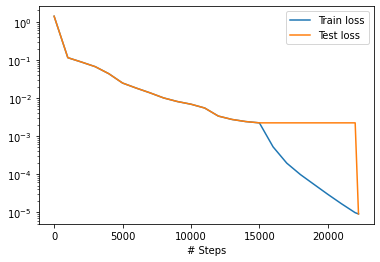

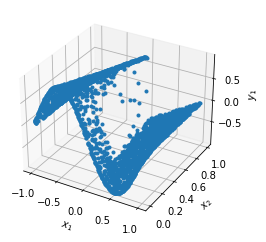

In [12]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

Let's compare the predicted solution with the real solution

In [14]:
from pathlib import Path

burguers_filepath = Path().resolve().parent / "data" / "Burgers.npz"
data = np.load(burguers_filepath)
t, x, exact = data["t"], data["x"], data["usol"].T
xx, tt = np.meshgrid(x, t)
X = np.vstack((np.ravel(xx), np.ravel(tt))).T
y_true = exact.flatten()[:, None]

y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

Mean residual: 0.008336143
L2 relative error: 0.05253457073427108
